# Chargement des données

In [119]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import MissingIndicator, KNNImputer,SimpleImputer
from sklearn.impute import IterativeImputer

import seaborn as sns

In [120]:
# Charger l'ensemble de données
df = pd.read_csv("horse.csv")
df.head(10)

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,...,45.0,8.4,NaN,NaN,died,no,11300,0,0,no
1,yes,adult,534817,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,...,50.0,85.0,cloudy,2.0,euthanized,no,2208,0,0,no
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,...,33.0,6.7,NaN,NaN,lived,no,0,0,0,yes
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,...,48.0,7.2,serosanguious,5.3,died,yes,2208,0,0,yes
4,no,adult,530255,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,...,74.0,7.4,NaN,NaN,died,no,4300,0,0,no
5,no,adult,528355,NaN,NaN,NaN,warm,normal,pale_pink,less_3_sec,...,NaN,NaN,NaN,NaN,lived,no,0,0,0,no
6,yes,adult,526802,37.9,48.0,16.0,normal,normal,normal_pink,less_3_sec,...,37.0,7.0,NaN,NaN,lived,yes,3124,0,0,no
7,yes,adult,529607,NaN,60.0,NaN,cool,NaN,NaN,less_3_sec,...,44.0,8.3,NaN,NaN,died,yes,2208,0,0,no
8,no,adult,530051,NaN,80.0,36.0,cool,absent,pale_pink,less_3_sec,...,38.0,6.2,NaN,NaN,euthanized,yes,3205,0,0,no
9,no,young,5299629,38.3,90.0,NaN,normal,NaN,normal_pink,less_3_sec,...,40.0,6.2,clear,2.2,lived,no,0,0,0,yes


In [121]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                299 non-null    object 
 1   age                    299 non-null    object 
 2   hospital_number        299 non-null    int64  
 3   rectal_temp            239 non-null    float64
 4   pulse                  275 non-null    float64
 5   respiratory_rate       241 non-null    float64
 6   temp_of_extremities    243 non-null    object 
 7   peripheral_pulse       230 non-null    object 
 8   mucous_membrane        252 non-null    object 
 9   capillary_refill_time  267 non-null    object 
 10  pain                   244 non-null    object 
 11  peristalsis            255 non-null    object 
 12  abdominal_distention   243 non-null    object 
 13  nasogastric_tube       195 non-null    object 
 14  nasogastric_reflux     193 non-null    object 
 15  nasoga

##Methodes de visualisation des valeurs manquantes

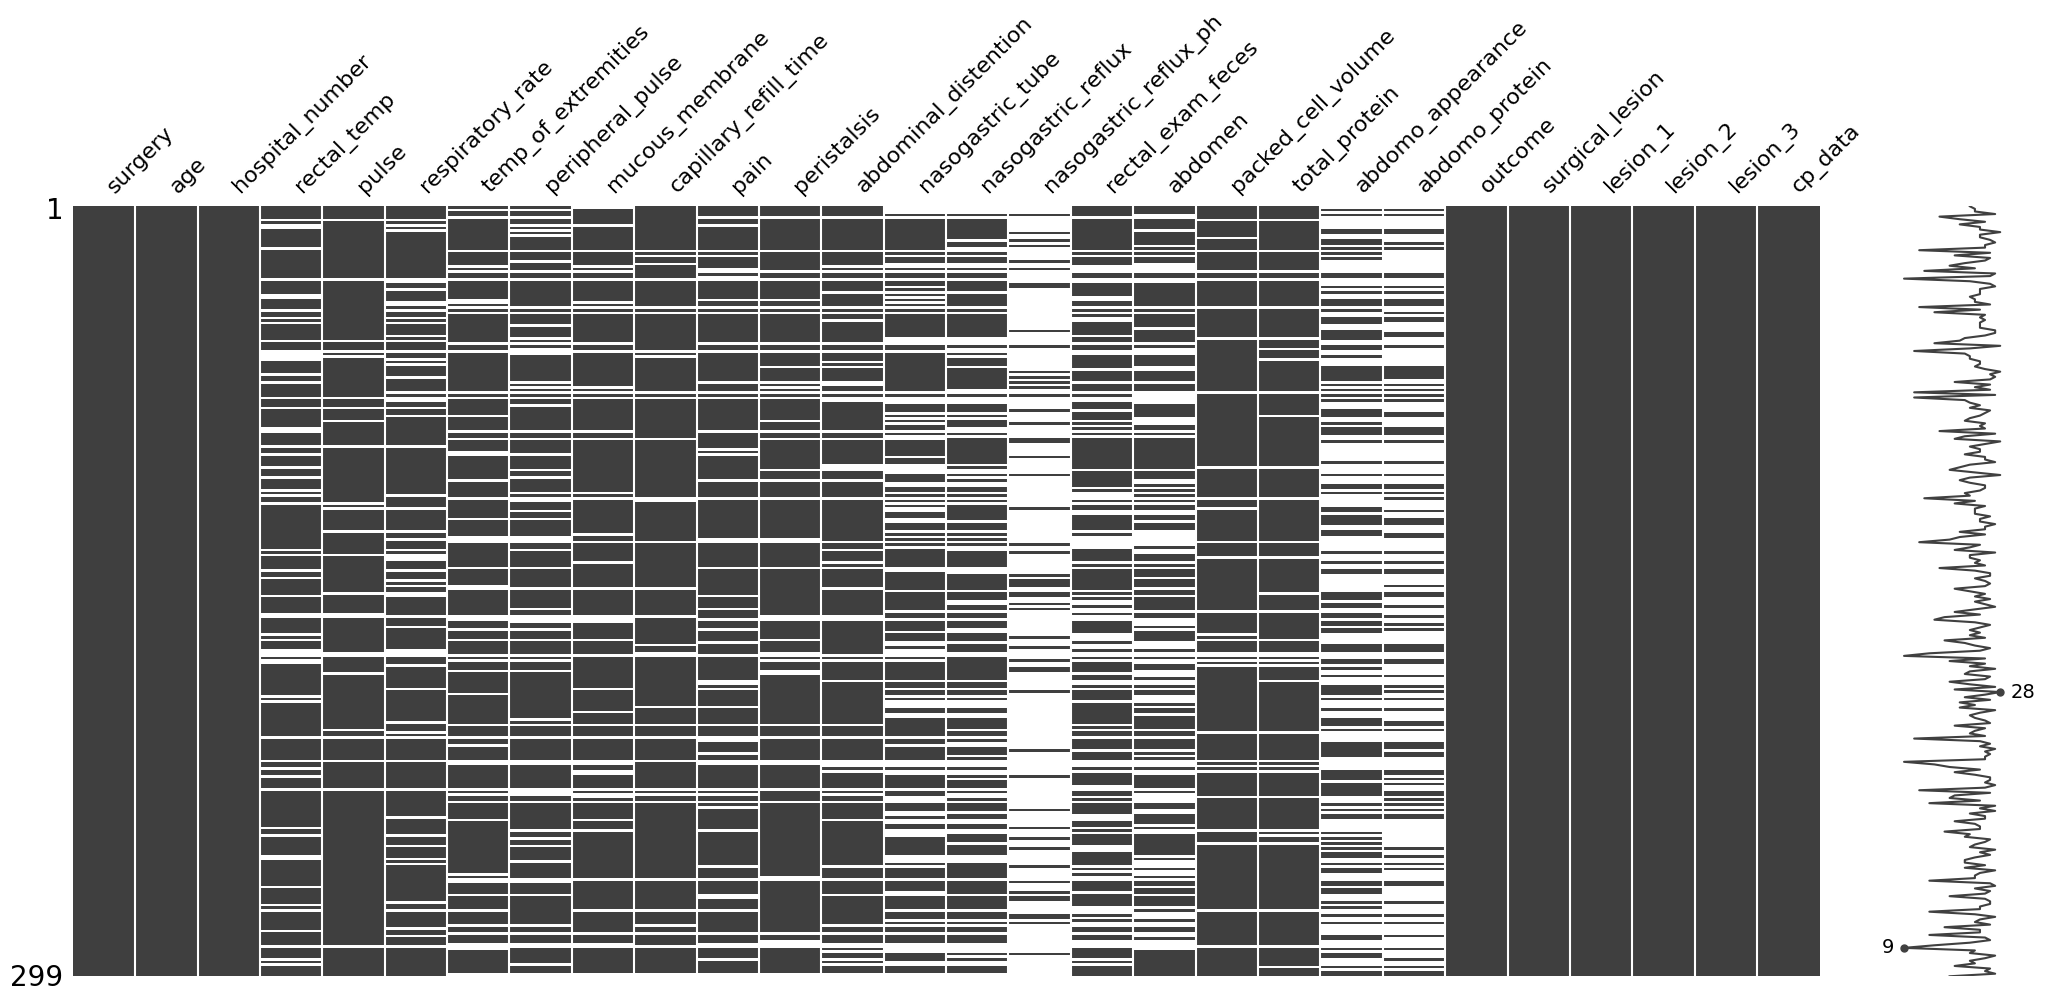

In [122]:
# Visualiser les valeurs manquantes
msno.matrix(df)
plt.show()

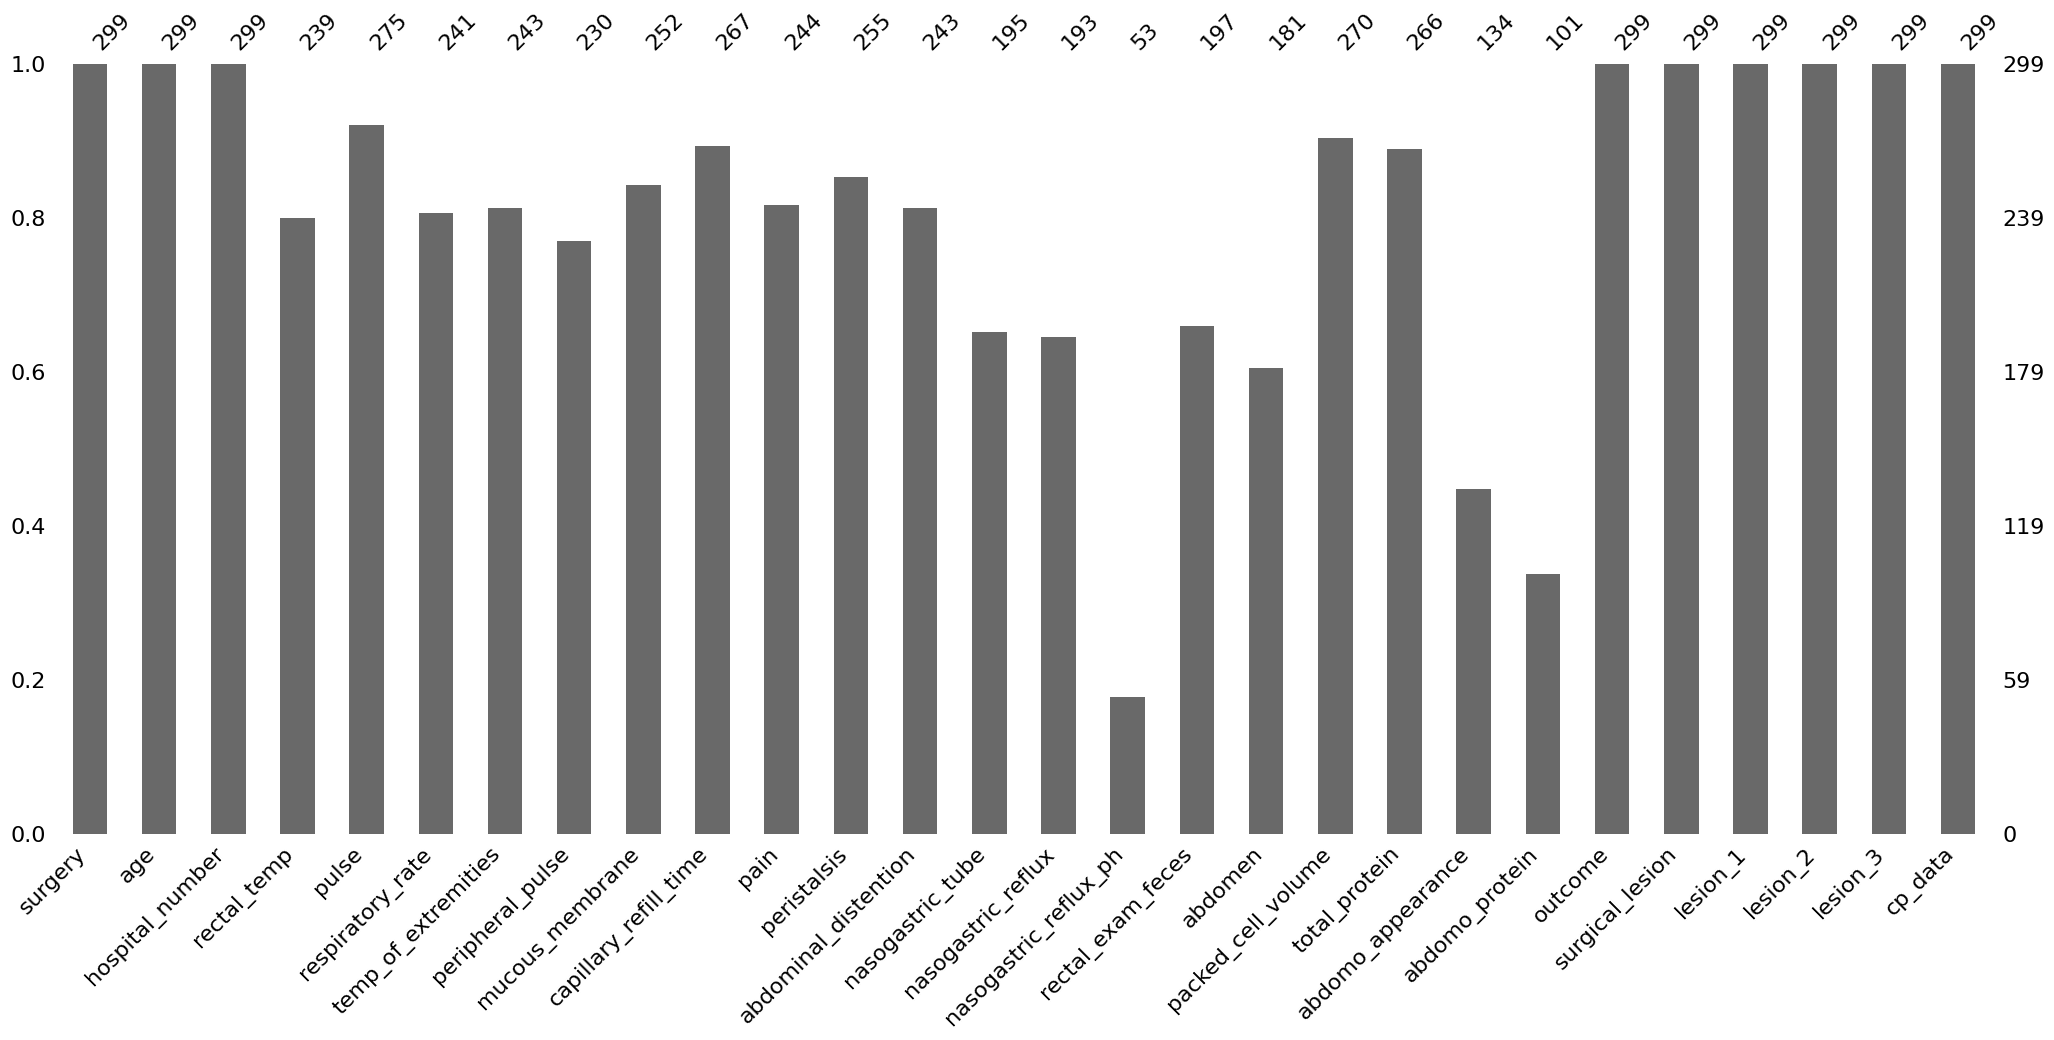

In [123]:
msno.bar(df)
plt.show()

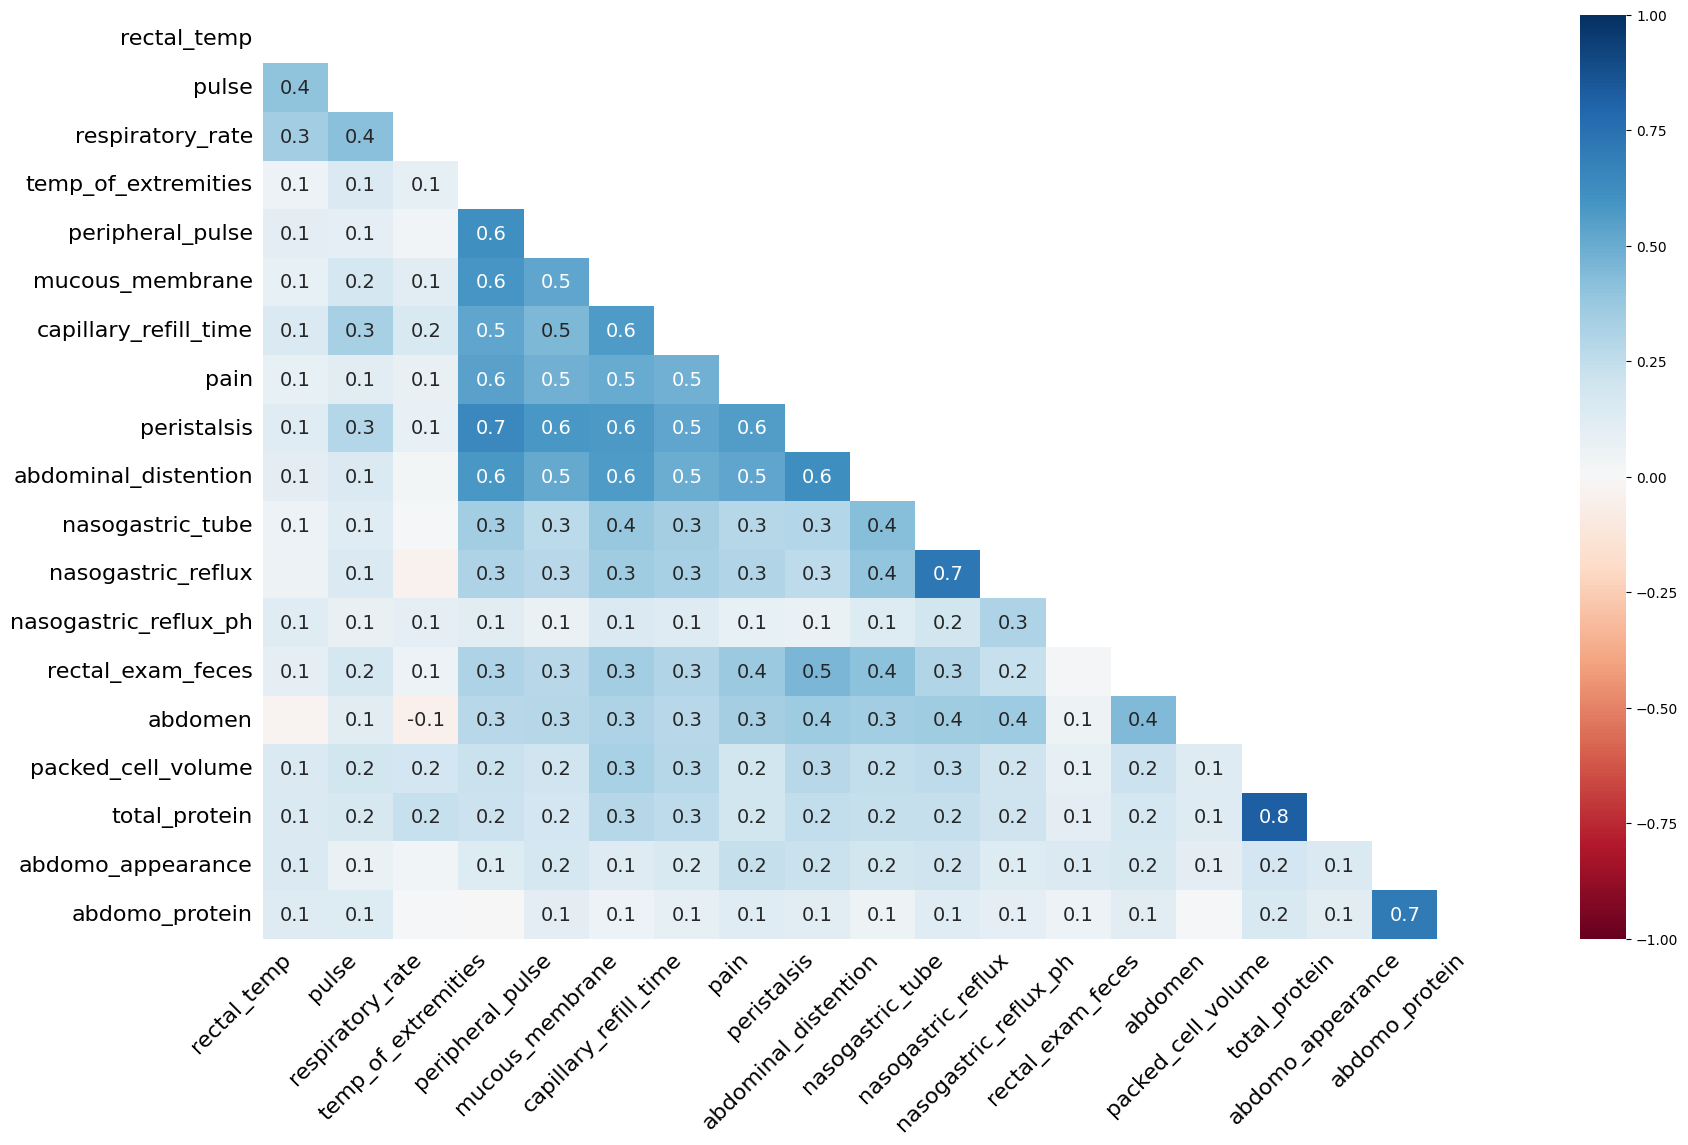

In [124]:
msno.heatmap(df)
plt.show()

# KNN imputer

Le KNNImputer de scikit-learn est un algorithme pour imputer les valeurs manquantes en utilisant les k plus proches voisins. Cette méthode non paramétrique utilise les valeurs des k plus proches voisins pour remplir les valeurs manquantes.
Le KNNImputer est particulièrement utile lorsque les données manquantes sont MCAR (Missing Completely At Random) ou MAR (Missing At Random), ce qui signifie que les valeurs manquantes ne dépendent pas de la valeur de la variable elle-même. Il peut être appliqué à des variables continues ou catégorielles. Cependant, il peut être plus lent que d'autres méthodes d'imputation, telles que l'imputation simple ou l'imputation par régression.

On imputera les valeurs manquantes en deux phases. Premièrement, les variables numériques seront remplacées par la moyenne des k plus proches voisins. Ensuite, les variables catégorielles seront codées et remplacées par le mode le plus fréquent des k plus proches voisins.

In [125]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

In [126]:
num_cols

Index(['hospital_number', 'rectal_temp', 'pulse', 'respiratory_rate',
       'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein',
       'abdomo_protein', 'lesion_1', 'lesion_2', 'lesion_3'],
      dtype='object')

In [127]:
cat_cols

Index(['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse',
       'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis',
       'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux',
       'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'outcome',
       'surgical_lesion', 'cp_data'],
      dtype='object')

In [128]:
#encoder les variables categorielle en n'encodant pas le NaN
from sklearn.preprocessing import LabelEncoder
from scipy.stats import mode
label_encoders = {}
df_encoded = df.copy()
for column in cat_cols:
    le = LabelEncoder()
    # Remplacer NaN par une valeur temporaire
    temp_col = df[column].fillna('TEMP_NA_VALUE')
    df_encoded[column] = le.fit_transform(temp_col)
    # Restaurer les NaN après l'encodage
    df_encoded.loc[df[column].isna(), column] = np.nan
    label_encoders[column] = le

In [129]:
# Afficher les correspondances des encodings
for column, le in label_encoders.items():
    print(f"Variable: {column}")
    for i, class_ in enumerate(le.classes_):
        print(f"  Encoded: {i} -> Original: {class_}")

Variable: surgery
  Encoded: 0 -> Original: no
  Encoded: 1 -> Original: yes
Variable: age
  Encoded: 0 -> Original: adult
  Encoded: 1 -> Original: young
Variable: temp_of_extremities
  Encoded: 0 -> Original: TEMP_NA_VALUE
  Encoded: 1 -> Original: cold
  Encoded: 2 -> Original: cool
  Encoded: 3 -> Original: normal
  Encoded: 4 -> Original: warm
Variable: peripheral_pulse
  Encoded: 0 -> Original: TEMP_NA_VALUE
  Encoded: 1 -> Original: absent
  Encoded: 2 -> Original: increased
  Encoded: 3 -> Original: normal
  Encoded: 4 -> Original: reduced
Variable: mucous_membrane
  Encoded: 0 -> Original: TEMP_NA_VALUE
  Encoded: 1 -> Original: bright_pink
  Encoded: 2 -> Original: bright_red
  Encoded: 3 -> Original: dark_cyanotic
  Encoded: 4 -> Original: normal_pink
  Encoded: 5 -> Original: pale_cyanotic
  Encoded: 6 -> Original: pale_pink
Variable: capillary_refill_time
  Encoded: 0 -> Original: 3
  Encoded: 1 -> Original: TEMP_NA_VALUE
  Encoded: 2 -> Original: less_3_sec
  Encoded: 3 -

In [130]:
df_encoded

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,0.0,0.0,530101,38.5,66.0,28.0,2.0,4.0,NaN,3.0,...,45.0,8.4,NaN,NaN,0.0,0.0,11300,0,0,0.0
1,1.0,0.0,534817,39.2,88.0,20.0,NaN,NaN,5.0,2.0,...,50.0,85.0,2.0,2.0,1.0,0.0,2208,0,0,0.0
2,0.0,0.0,530334,38.3,40.0,24.0,3.0,3.0,6.0,2.0,...,33.0,6.7,NaN,NaN,2.0,0.0,0,0,0,1.0
3,1.0,1.0,5290409,39.1,164.0,84.0,1.0,3.0,3.0,3.0,...,48.0,7.2,3.0,5.3,0.0,1.0,2208,0,0,1.0
4,0.0,0.0,530255,37.3,104.0,35.0,NaN,NaN,3.0,3.0,...,74.0,7.4,NaN,NaN,0.0,0.0,4300,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,1.0,0.0,533886,NaN,120.0,70.0,1.0,NaN,5.0,3.0,...,55.0,65.0,NaN,NaN,1.0,0.0,3205,0,0,0.0
295,0.0,0.0,527702,37.2,72.0,24.0,2.0,2.0,5.0,3.0,...,44.0,NaN,3.0,3.3,1.0,1.0,2208,0,0,1.0
296,1.0,0.0,529386,37.5,72.0,30.0,1.0,4.0,5.0,2.0,...,60.0,6.8,NaN,NaN,0.0,1.0,3205,0,0,0.0
297,1.0,0.0,530612,36.5,100.0,24.0,2.0,4.0,6.0,2.0,...,50.0,6.0,3.0,3.4,2.0,1.0,2208,0,0,1.0


In [131]:
#variable numerique
imputer_num = KNNImputer(n_neighbors=3)
df_encoded[num_cols] = imputer_num.fit_transform(df_encoded[num_cols])

In [132]:
df_encoded

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,0.0,0.0,530101.0,38.5,66.0,28.0,2.0,4.0,NaN,3.0,...,45.0,8.400000,NaN,3.666667,0.0,0.0,11300.0,0.0,0.0,0.0
1,1.0,0.0,534817.0,39.2,88.0,20.0,NaN,NaN,5.0,2.0,...,50.0,85.000000,2.0,2.000000,1.0,0.0,2208.0,0.0,0.0,0.0
2,0.0,0.0,530334.0,38.3,40.0,24.0,3.0,3.0,6.0,2.0,...,33.0,6.700000,NaN,3.966667,2.0,0.0,0.0,0.0,0.0,1.0
3,1.0,1.0,5290409.0,39.1,164.0,84.0,1.0,3.0,3.0,3.0,...,48.0,7.200000,3.0,5.300000,0.0,1.0,2208.0,0.0,0.0,1.0
4,0.0,0.0,530255.0,37.3,104.0,35.0,NaN,NaN,3.0,3.0,...,74.0,7.400000,NaN,3.000000,0.0,0.0,4300.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,1.0,0.0,533886.0,38.2,120.0,70.0,1.0,NaN,5.0,3.0,...,55.0,65.000000,NaN,2.000000,1.0,0.0,3205.0,0.0,0.0,0.0
295,0.0,0.0,527702.0,37.2,72.0,24.0,2.0,2.0,5.0,3.0,...,44.0,7.066667,3.0,3.300000,1.0,1.0,2208.0,0.0,0.0,1.0
296,1.0,0.0,529386.0,37.5,72.0,30.0,1.0,4.0,5.0,2.0,...,60.0,6.800000,NaN,3.033333,0.0,1.0,3205.0,0.0,0.0,0.0
297,1.0,0.0,530612.0,36.5,100.0,24.0,2.0,4.0,6.0,2.0,...,50.0,6.000000,3.0,3.400000,2.0,1.0,2208.0,0.0,0.0,1.0


In [133]:
# Pour les variables catégorielles, utiliser le mode des k voisins les plus proches
for column in cat_cols:
    mask = df[column].isna()
    if mask.sum() > 0:
        # Extraire les observations avec des valeurs manquantes
        missing_indices = df.index[mask]

        # Appliquer l'imputation KNN
        df_imputed = imputer_num.fit_transform(df_encoded)

        # Extraire les valeurs des k voisins pour les indices manquants
        neighbors = df_imputed[missing_indices, :]

        # Trouver le mode parmi les voisins pour chaque valeur manquante
        mode_values = mode(neighbors, axis=0, nan_policy='omit').mode[0]

        # Imputer les valeurs manquantes avec le mode
        df_encoded.loc[missing_indices, column] = mode_values


In [134]:
df_encoded

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,0.0,0.0,530101.0,38.5,66.0,28.0,2.0,4.0,1.0,3.0,...,45.0,8.400000,1.0,3.666667,0.0,0.0,11300.0,0.0,0.0,0.0
1,1.0,0.0,534817.0,39.2,88.0,20.0,1.0,1.0,5.0,2.0,...,50.0,85.000000,2.0,2.000000,1.0,0.0,2208.0,0.0,0.0,0.0
2,0.0,0.0,530334.0,38.3,40.0,24.0,3.0,3.0,6.0,2.0,...,33.0,6.700000,1.0,3.966667,2.0,0.0,0.0,0.0,0.0,1.0
3,1.0,1.0,5290409.0,39.1,164.0,84.0,1.0,3.0,3.0,3.0,...,48.0,7.200000,3.0,5.300000,0.0,1.0,2208.0,0.0,0.0,1.0
4,0.0,0.0,530255.0,37.3,104.0,35.0,1.0,1.0,3.0,3.0,...,74.0,7.400000,1.0,3.000000,0.0,0.0,4300.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,1.0,0.0,533886.0,38.2,120.0,70.0,1.0,1.0,5.0,3.0,...,55.0,65.000000,1.0,2.000000,1.0,0.0,3205.0,0.0,0.0,0.0
295,0.0,0.0,527702.0,37.2,72.0,24.0,2.0,2.0,5.0,3.0,...,44.0,7.066667,3.0,3.300000,1.0,1.0,2208.0,0.0,0.0,1.0
296,1.0,0.0,529386.0,37.5,72.0,30.0,1.0,4.0,5.0,2.0,...,60.0,6.800000,1.0,3.033333,0.0,1.0,3205.0,0.0,0.0,0.0
297,1.0,0.0,530612.0,36.5,100.0,24.0,2.0,4.0,6.0,2.0,...,50.0,6.000000,3.0,3.400000,2.0,1.0,2208.0,0.0,0.0,1.0


In [135]:
print(df_encoded.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                299 non-null    float64
 1   age                    299 non-null    float64
 2   hospital_number        299 non-null    float64
 3   rectal_temp            299 non-null    float64
 4   pulse                  299 non-null    float64
 5   respiratory_rate       299 non-null    float64
 6   temp_of_extremities    299 non-null    float64
 7   peripheral_pulse       299 non-null    float64
 8   mucous_membrane        299 non-null    float64
 9   capillary_refill_time  299 non-null    float64
 10  pain                   299 non-null    float64
 11  peristalsis            299 non-null    float64
 12  abdominal_distention   299 non-null    float64
 13  nasogastric_tube       299 non-null    float64
 14  nasogastric_reflux     299 non-null    float64
 15  nasoga